In [6]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features
from src.visualization import visualize

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

DIAGS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J91X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

DIAGS_FALTANTES_PULMON = ["C349", "C348"]

DIAGS_RELEVANTES += DIAGS_FALTANTES_PULMON

In [42]:
# Carga los egresos nacionales
egresos_nacionales = pd.read_csv(
    "../data/processed/ranking_nacional_egresos.csv", sep=";", encoding="latin-1"
)

# Filtra solamente los datos del INT
egresos_torax = egresos_nacionales.query("ESTABLECIMIENTO_SALUD == 112103").copy()

In [43]:
# Filtra solamente los diagnosticos mas relevantes del Torax
egresos_mas_relevantes_nacionales = (
    egresos_nacionales[egresos_nacionales["DIAG1"].isin(DIAGS_RELEVANTES)]
    .query("ANO_EGRESO >= 2017")
    .copy()
)

egresos_mas_relevantes_nacionales["DIAG1"] = egresos_mas_relevantes_nacionales["DIAG1"].replace(
    ["C340", "C341", "C342", "C343", "C348", "C349"], "C34"
)

In [49]:
# Obtiene cantidad de pacientes, egresos y dias de estada por diagnostico
resumen_egresos_mas_relevantes_nacionales = pd.pivot_table(
    egresos_mas_relevantes_nacionales,
    index="DIAG1",
    columns="ANO_EGRESO",
    values=["n_pacientes_distintos", "n_egresos", "dias_estada_totales"],
    aggfunc="sum",
    fill_value=0,
).sort_index()

In [50]:
# Importa los casos teoricos por cada problema de salud
casos_teoricos = pd.read_excel("../data/interim/casos_teoricos_diagnosticos.xlsx")
casos_teoricos["Diagnostico"] = casos_teoricos["Diagnostico"].str.split("-").str[0].str.strip()
casos_teoricos = casos_teoricos.set_index("Diagnostico")

# Obtiene los casos en el estrato nacional
casos_nacionales = casos_teoricos.query("Estrato == 'Pais' and Estadística == 'Incidencia'").copy()
casos_nacionales_del_2017_al_2020 = casos_nacionales[[f"Poblacion {i}" for i in range (2017, 2021)]]

In [51]:
# Une la cantidad de casos teoricos y reales
union_de_pacientes_teoricos_y_vistos = casos_nacionales_del_2017_al_2020.merge(
    resumen_egresos_mas_relevantes_nacionales["n_pacientes_distintos"],
    how="left",
    left_index=True,
    right_index=True,
)

# Renombra las columnas
niveles_columnas = [
    ("poblacion_teorica", "2017"),
    ("poblacion_teorica", "2018"),
    ("poblacion_teorica", "2019"),
    ("poblacion_teorica", "2020"),
    ("poblacion_vista", "2017"),
    ("poblacion_vista", "2018"),
    ("poblacion_vista", "2019"),
    ("poblacion_vista", "2020"),
]

union_de_pacientes_teoricos_y_vistos.columns = pd.MultiIndex.from_tuples(niveles_columnas)

# Calcula la cantidad de cumplimiento de los casos teoricos
porcentaje_de_atencion_casos_teoricos = (
    union_de_pacientes_teoricos_y_vistos["poblacion_vista"].sum(axis=1)
    / union_de_pacientes_teoricos_y_vistos["poblacion_teorica"].sum(axis=1)
)

In [52]:
proyeccion_de_casos_a_atender = casos_nacionales[[f"Poblacion {i}" for i in range(2017, 2036)]].mul(
    porcentaje_de_atencion_casos_teoricos, axis=0
)

In [54]:
# Obtiene egresos por caso por diagnostico
egresos_por_persona_nacionales = resumen_egresos_mas_relevantes_nacionales["n_egresos"].sum(
    axis=1
) / resumen_egresos_mas_relevantes_nacionales["n_pacientes_distintos"].sum(axis=1)

# Obtiene dias de estada por egreso
dias_de_estada_por_egreso_nacionales = resumen_egresos_mas_relevantes_nacionales["dias_estada_totales"].sum(
    axis=1
) / resumen_egresos_mas_relevantes_nacionales["n_egresos"].sum(axis=1)

In [55]:
# Obtiene la cantidad de egresos, dias de estada y camas por la proyeccion
proyeccion_de_egresos = proyeccion_de_casos_a_atender.mul(egresos_por_persona_nacionales, axis=0)
proyeccion_de_dias_de_estada = proyeccion_de_egresos.mul(dias_de_estada_por_egreso_nacionales, axis=0)
proyeccion_de_camas_a_tener = proyeccion_de_dias_de_estada / 365.25

<Axes: >

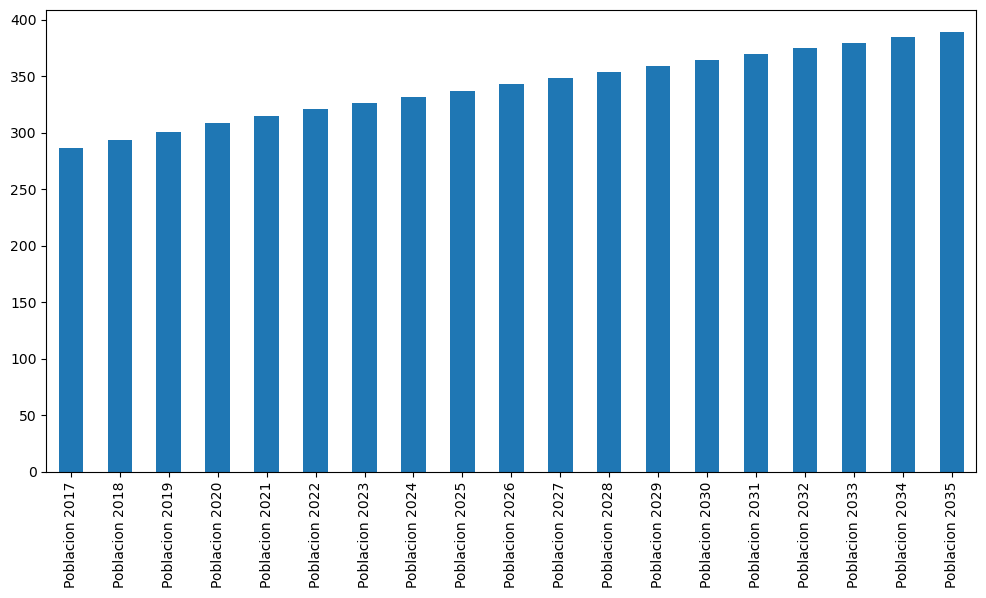

In [56]:
proyeccion_de_camas_a_tener.sum().plot(kind="bar")